In [1]:
import os
import numpy as np
import torch
import torch.optim as optim
import torch.distributions as D
from tqdm import tqdm, trange
from src.svgd import SVGD
from src.gsvgd import FullGSVGDBatch
from src.kernel import RBF, BatchRBF
from src.utils import plot_particles
from src.Tmy_svgd import etmySVGD
from src.manifold import Grassmann
from src.s_svgd import SlicedSVGD

import matplotlib.pyplot as plt
from src.rand_mysvgd import min_mySVGD
from scipy.stats import energy_distance
import pickle
import argparse
import time

import torch.autograd as autograd

def mix_gauss_experiment(mixture_dist, means):
    '''Mixture of Multivariate gaussian with cov matrices being the identity.
    Args:
        probs: Tensor of shape (nmix,) for the mixture_distribution.
        means: Tensor of shape (nmix, d), where nmix is the number of components 
            and d is the dimension of each component.
    '''
    nmix = means.shape[0]
    comp = D.Independent(D.Normal(means.to(device), torch.ones((nmix, means.shape[1]), device=device)), 1)
    distribution = D.mixture_same_family.MixtureSameFamily(mixture_dist, comp) 
    return distribution


def points_on_circle(theta, rad):
    '''Generate d-dim points whose first two dimensions lies on a circle of 
    radius rad, with position being specified by the angle from the positive 
    x-axis theta.
    '''
    return torch.Tensor([[rad * np.cos(theta + 0.25*np.pi), rad * np.sin(theta + 0.25*np.pi)]])

parser = argparse.ArgumentParser(description='Running xshaped experiment.')
parser.add_argument('--dim', type=int,default=20, help='dimension')
parser.add_argument('--effdim', type=int, default=-1, help='dimension')
parser.add_argument('--lr', type=float,default=0.01, help='learning rate')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for g')
parser.add_argument('--delta', type=float,default=0.01, help='stepsize for projections')
parser.add_argument('--T', type=float, default=1e-4, help='noise multiplier for projections')
parser.add_argument('--nparticles', type=int,default=100, help='no. of particles')
parser.add_argument('--epochs', type=int, default=10000,help='no. of epochs')
parser.add_argument('--nmix', type=int, default=2, help='no. of modes')
parser.add_argument('--metric', type=str, default="energy", help='distance metric')
parser.add_argument('--noise', type=str, default="True", help='whether to add noise')
parser.add_argument('--kernel', type=str, default="rbf", help='kernel')
parser.add_argument('--gpu', type=int, default=2, help='gpu')
parser.add_argument('--seed', type=int, default=0, help='random seed') 
parser.add_argument('--suffix', type=str, default="", help='suffix for res folder')
parser.add_argument('--m', type=int, help='no. of projections')
parser.add_argument('--save_every', type=int, default=200, help='step intervals to save particles')
parser.add_argument('--method', type=str, default="all", help='which method to use')


/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


_StoreAction(option_strings=['--method'], dest='method', nargs=None, const=None, default='all', type=<class 'str'>, choices=None, required=False, help='which method to use', metavar=None)

In [2]:
args = parser.parse_args([])
device = torch.device(f'cuda:{args.gpu}' if args.gpu != -1 else 'cpu')
dim = args.dim
lr = args.lr
delta = args.delta
T = args.T
nparticles = args.nparticles
epochs = args.epochs
seed = args.seed
eff_dims = [args.effdim] if args.effdim > 0 else [1, 2, 5]
nmix = args.nmix
add_noise = True if args.noise == "True" else False
radius = 5
save_every = args.save_every
print(f"Running for dim: {dim}, lr: {lr}, nparticles: {nparticles}")

Running for dim: 20, lr: 0.01, nparticles: 100


In [3]:



if args.kernel == "rbf":
    Kernel = RBF
    BatchKernel = BatchRBF

In [4]:
def mix_gauss_experiment(mixture_dist, means):
    '''Mixture of Multivariate gaussian with cov matrices being the identity.
    Args:
        probs: Tensor of shape (nmix,) for the mixture_distribution.
        means: Tensor of shape (nmix, d), where nmix is the number of components 
            and d is the dimension of each component.
    '''
    nmix = means.shape[0]
    comp = D.Independent(D.Normal(means.to(device), torch.ones((nmix, means.shape[1]), device=device)), 1)
    distribution = D.mixture_same_family.MixtureSameFamily(mixture_dist, comp) 
    return distribution


def points_on_circle(theta, rad):
    '''Generate d-dim points whose first two dimensions lies on a circle of 
    radius rad, with position being specified by the angle from the positive 
    x-axis theta.
    '''
    return torch.Tensor([[rad * np.cos(theta + 0.25*np.pi), rad * np.sin(theta + 0.25*np.pi)]])

In [5]:
## target density
mix_means = torch.cat(
[points_on_circle(i * 2*np.pi / nmix, rad=radius) for i in range(nmix)]).to(device)
mix_means = torch.cat((mix_means, torch.zeros((mix_means.shape[0], dim - 2), device=device)), dim=1)

distribution = mix_gauss_experiment(
mixture_dist=D.Categorical(torch.ones(mix_means.shape[0], device=device)),
means=mix_means
)

In [6]:
def score(X):
        X_cp = X.clone().detach().requires_grad_()
        log_prob = distribution.log_prob(X_cp)
        score_func = autograd.grad(log_prob.sum(), X_cp)[0]
        return score_func

In [7]:
print(f"Running for dim: {dim}")
print("#####################################################")

## target density
print(f"Device: {device}")




print(f"Running for dim: {dim}")
print("#####################################################")

## target density
print(f"Device: {device}")

means = torch.zeros(dim, device=device)

torch.manual_seed(0)


cov = torch.eye(dim, device=device)

distribution = D.MultivariateNormal(means.to(device), cov)

# sample from target (for computing metric)
x_target = distribution.sample((nparticles, ))
# sample from variational density
torch.manual_seed(235)
x_init = 2 + np.sqrt(2) * torch.randn(nparticles, *distribution.event_shape, device=device)






    

print("Running SVGD >>>>>>>>>>>>>>>>>>")
# sample from variational density
x = x_init.clone().to(device)
kernel = Kernel(method="med_heuristic")
svgd = SVGD(distribution, kernel, optim.Adam([x], lr=lr), device=device)

svgd.fit(x, epochs, verbose=True, save_every=save_every)
    

theta_svgd = x
    





print('Running mysvgd >>>>>>>>>>>>>>>>>>>>>>>')



x0 = x_init.clone().to(device)
vector1  = torch.zeros_like(x0).to(device)


lr = 0.03
theta, vector = etmySVGD(kernel,device).update(x0, score, k = 2, n_iter = 10000,   lr= lr, vector=vector1)
theta_mysvgd = theta

Running for dim: 20
#####################################################
Device: cuda:2
Running for dim: 20
#####################################################
Device: cuda:2
Running SVGD >>>>>>>>>>>>>>>>>>


100%|██████████| 10000/10000 [00:21<00:00, 470.77it/s]


Running mysvgd >>>>>>>>>>>>>>>>>>>>>>>


100%|██████████| 10000/10000 [09:37<00:00, 17.32it/s]


In [8]:
def xshaped_gauss_experiment(mixture_dist, means, correlation):
    '''Mixture of Multivariate gaussian with cov matrices being the identity.
    Args:
        mixture_dist: torch.distributions.Categorical-like instance for the 
            probability of each component in the mixture.
        means: Tensor of shape (nmix, d), where nmix is the number of components 
            and d is the dimension of each component.
        correlation: Float between 0 and 1 for the magnitude of correlation between
            the first two dims.
    '''
    nmix, dim = means.shape
    nmix = nmix + 1
    
    # create multibatch multivariate Gaussian
    cov1 = torch.eye(dim, device=device)
    cov1[:2, :2] = torch.Tensor([[2, 1.9],[1.9, 2]])
   
    
    #cov1[dim-2:, dim-2:] = torch.Tensor([[1, correlation], [correlation, 1]])
    cov2 = torch.eye(dim, device=device)
    cov2[:2, :2] = torch.Tensor([[2, 0], [0, 2]])
    #cov2[dim-2:, dim-2:] = torch.Tensor([[1, 0], [0, 1]])
   
    mix_cov = torch.stack((cov1, cov2))
   
    comp = D.MultivariateNormal(means.to(device), mix_cov)

    distribution = D.mixture_same_family.MixtureSameFamily(mixture_dist, comp)   
    return(distribution)

parser = argparse.ArgumentParser(description='Running xshaped experiment.')
parser.add_argument('--dim', type=int,default=20, help='dimension')
parser.add_argument('--effdim', type=int, default=-1, help='dimension')
parser.add_argument('--lr', type=float,default=0.01, help='learning rate')
parser.add_argument('--lr_g', type=float, default=0.1, help='learning rate for g')
parser.add_argument('--delta', type=float,default=0.01, help='stepsize for projections')
parser.add_argument('--T', type=float, default=1e-4, help='noise multiplier for projections')
parser.add_argument('--nparticles', type=int,default=100, help='no. of particles')
parser.add_argument('--epochs', type=int, default=20000,help='no. of epochs')
parser.add_argument('--nmix', type=int, default=4, help='no. of modes')
parser.add_argument('--metric', type=str, default="energy", help='distance metric')
parser.add_argument('--noise', type=str, default="True", help='whether to add noise')
parser.add_argument('--kernel', type=str, default="rbf", help='kernel')
parser.add_argument('--gpu', type=int, default=2, help='gpu')
parser.add_argument('--seed', type=int, default=235, help='random seed') 
parser.add_argument('--suffix', type=str, default="", help='suffix for res folder')
parser.add_argument('--m', type=int, help='no. of projections')
parser.add_argument('--save_every', type=int, default=200, help='step intervals to save particles')
parser.add_argument('--method', type=str, default="all", help='which method to use')


args = parser.parse_args([])
dim = args.dim
lr = args.lr
delta = args.delta
T = args.T
nparticles = args.nparticles
epochs = args.epochs
seed = args.seed
eff_dims = [args.effdim] if args.effdim > 0 else [1, 2, 5]
add_noise = True if args.noise == "True" else False
correlation = 0.95
save_every = args.save_every
device = torch.device(f'cuda:{args.gpu}' if args.gpu != -1 else 'cpu')
print(f"Running for dim: {dim}, lr: {lr}, nparticles: {nparticles}")

Running for dim: 20, lr: 0.01, nparticles: 100


In [9]:
print(f"Running for dim: {dim}")
print("#####################################################")

## target density
mix_means_x = torch.zeros((2, dim), device=device)
mix_means_x[:, :2] = 0

distribution_x = xshaped_gauss_experiment(
    mixture_dist=D.Categorical(torch.ones(mix_means_x.shape[0], device=device)),
    means=mix_means_x,
    correlation=correlation
)


# sample from target (for computing metric)



# sample from variational density
x_init_x =  torch.randn(nparticles, *distribution_x.event_shape).to(device)

## SVGD

def score(X):
    X_cp = X.clone().detach().requires_grad_()
    log_prob = distribution_x.log_prob(X_cp)
    score_func = autograd.grad(log_prob.sum(), X_cp)[0]
    return score_func

    

print("Running SVGD >>>>>>>>>>>>>>>>>>")
# sample from variational density
x = x_init_x.clone().to(device)
kernel = Kernel(method="med_heuristic")
svgd = SVGD(distribution_x, kernel, optim.Adam([x], lr=lr), device=device)

svgd.fit(x, epochs, verbose=True, save_every=save_every)


xtheta_svgd = x
    






print('Running mysvgd >>>>>>>>>>>>>>>>>>>>>>>')



x0 = x_init_x.clone().to(device)
vector1  = torch.randn(nparticles, dim).to(device)


    
theta, vector = etmySVGD(kernel,device).update(x0, score, k = 2, n_iter = 10000,  lr= lr, vector=vector1)
xtheta_mysvgd = theta

Running for dim: 20
#####################################################
Running SVGD >>>>>>>>>>>>>>>>>>


100%|██████████| 20000/20000 [00:51<00:00, 385.00it/s]


Running mysvgd >>>>>>>>>>>>>>>>>>>>>>>


100%|██████████| 10000/10000 [09:32<00:00, 17.46it/s]


In [10]:

P = distribution
P_x = distribution_x
d = 7.0
step = 0.1
concat = mix_means[0, 2:]
concat_x = mix_means_x[0, 2:]

xv, yv = torch.meshgrid([torch.arange(-d, d, step), torch.arange(-d, d, step)])
xv, yv = xv.to(x_init.device), yv.to(x_init.device)
pos_xy = torch.cat((xv.unsqueeze(-1), yv.unsqueeze(-1)), dim=-1).to(x_init.device)
if P.event_shape[0] > 2:
# assert concat is not None, "Need to specify concat in dim larger than 2."
    if concat is None:
        print(("Concatenating higher dims with vector of zeros. Customize by "
            "using the concat argument."))
        concat = torch.zeros((1, P.event_shape[0] - 2)).to(x_init.device)

    pos_xy = torch.cat(
        (pos_xy, concat.repeat(pos_xy.shape[0], pos_xy.shape[1], 1)), 
        dim=2).to(x_init.device)
p_xy = P.log_prob(pos_xy).exp().unsqueeze(-1)
xv, yv, x_init, theta_svgd, p_xy = xv.to("cpu"), yv.to("cpu"), x_init.to("cpu"), theta_svgd.to("cpu"), p_xy.to("cpu")
xv, yv, x_init, theta_mysvgd, p_xy = xv.to("cpu"), yv.to("cpu"), x_init.to("cpu"), theta_mysvgd.to("cpu"), p_xy.to("cpu")




xxv, xyv = torch.meshgrid([torch.arange(-d, d, step), torch.arange(-d, d, step)])
xxv, xyv = xxv.to(x_init_x.device), xyv.to(x_init_x.device)
xpos_xy = torch.cat((xxv.unsqueeze(-1), xyv.unsqueeze(-1)), dim=-1).to(x_init_x.device)
if P_x.event_shape[0] > 2:
# assert concat is not None, "Need to specify concat in dim larger than 2."
    if concat_x is None:
        print(("Concatenating higher dims with vector of zeros. Customize by "
            "using the concat argument."))
        concat_x = torch.zeros((1, P_x.event_shape[0] - 2)).to(x_init_x.device)

    xpos_xy = torch.cat(
        (xpos_xy, concat_x.repeat(xpos_xy.shape[0], xpos_xy.shape[1], 1)), 
        dim=2).to(x_init_x.device)
xp_xy = P_x.log_prob(xpos_xy).exp().unsqueeze(-1)
xxv, xyv, x_init_x, xtheta_svgd, xp_xy = xxv.to("cpu"), xyv.to("cpu"), x_init_x.to("cpu"), xtheta_svgd.to("cpu"), xp_xy.to("cpu")
xxv, xyv, x_init_x, xtheta_mysvgd, xp_xy = xxv.to("cpu"), xyv.to("cpu"), x_init_x.to("cpu"), xtheta_mysvgd.to("cpu"), xp_xy.to("cpu")



/home/zhoujk/anaconda3/envs/AG/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
theta_svgd = theta_svgd.detach().numpy()
theta_mysvgd = theta_mysvgd.detach().numpy()

xtheta_svgd = xtheta_svgd.detach().numpy()
xtheta_mysvgd = xtheta_mysvgd.detach().numpy()

Text(0.5, 1.0, 'SVGD')

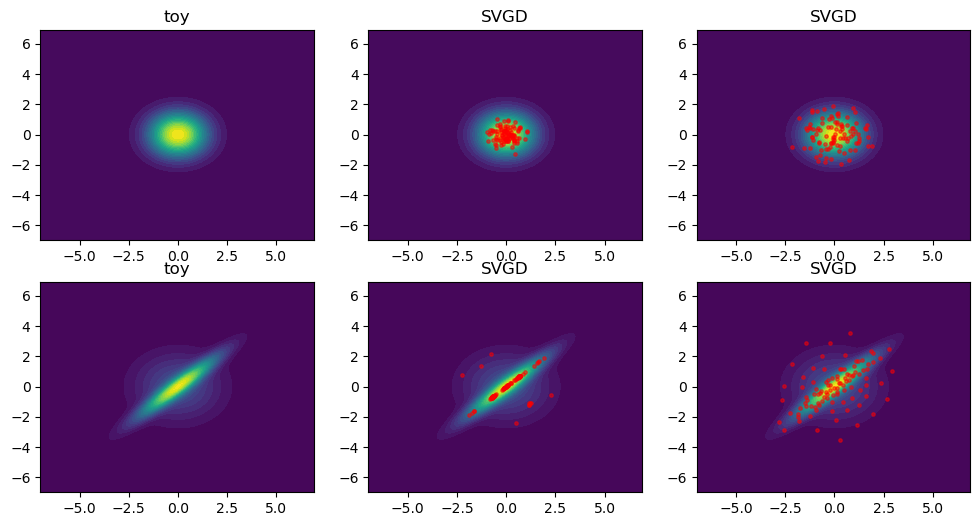

In [12]:
figsize = (12,6)
fig = plt.figure(figsize=figsize)
plt.subplot(2, 3, 1)
plt.contourf(xv, yv, p_xy.squeeze(-1), levels=20)
plt.title("toy")
plt.subplot(2, 3, 2)
plt.contourf(xv, yv, p_xy.squeeze(-1), levels=20)
plt.scatter(theta_svgd[:, 0], theta_svgd[:, 1], color="r", alpha=0.5, s=6)
plt.title("SVGD")
plt.subplot(2, 3, 3)
plt.contourf(xv, yv, p_xy.squeeze(-1), levels=20)
plt.scatter(theta_mysvgd[:, 0], theta_mysvgd[:, 1], color="r", alpha=0.5, s=6)
plt.title("SVGD")



plt.subplot(2, 3, 4)
plt.contourf(xxv, xyv, xp_xy.squeeze(-1), levels=30)
plt.title("toy")
plt.subplot(2, 3, 5)
plt.contourf(xxv, xyv, xp_xy.squeeze(-1), levels=30)
plt.scatter(xtheta_svgd[:, 0], xtheta_svgd[:, 1], color="r", alpha=0.5, s=6)
plt.title("SVGD")
plt.subplot(2, 3, 6)
plt.contourf(xxv, xyv, xp_xy.squeeze(-1), levels=30)
plt.scatter(xtheta_mysvgd[:, 0], xtheta_mysvgd[:, 1], color="r", alpha=0.5, s=6)
plt.title("SVGD")
